# Waste Image Classification

# Section 0 - Introduction 

### Problem Statement

The recycling process requires people to sort their trash and their recycables into separate bins. However, most of the time, this is a tedious task. Additionally, recycling guidelines are oftentimes ignored, resulting in mixed recycling or even trash ending up in the recycling bins which can cause contamination and various other problems down the line. Also, poor judgement about whether an item is, for example, a tetra pack or a plastic can lead to the missclassification of waste. 

A computer vision-based waste management system (waste sorting machine) would solve many of these problems. The system would be able to scan an item, identify its waste class and automatically ship the item to the correct bin from a centralized pool of recycable waste.

### Objective

The objective of this project is to train a model using images of different types of recycable waste from the training dataset 
- to accurately classify a given image from the validation dataset into one of the waste categories, and
- to accurately distinguish between different types of waste.

### Data

The dataset consists of over 2000 samples. One sample presents an image of one or more items that belong to one type of recycable waste. 

The images were downloaded from Google images and divided into 9 folders, each representing one type of recycable waste. There are around 300 images of each type/in each folder. The data is stored on Kaggle and will need to be downloaded for use. 

# Section 1 - Setup

In [ ]:
# !pip install opendatasets

In [9]:
# Import needed libraries and modules

import opendatasets as od
import os
from fastai.vision.all import *
from fastai.data.all import *
from fastai.metrics import accuracy 
from time import time
import matplotlib.pyplot as plt
from random import randint

%matplotlib inline 

# Section 2 - Downloading the Image Data

In [ ]:
# Download the data from Kaggle

# To download the dataset, you must have an account on Kaggle. 
# For further instructions on how to find your Kaggle username and Kaggle Key, refer to the link below:
# https://www.analyticsvidhya.com/blog/2021/04/how-to-download-kaggle-datasets-using-jupyter-notebook/ 

od.download("https://www.kaggle.com/sanjadrag24/waste-images")

# Section 3 - Preparing the Image dataset

In [10]:
# The images were downloaded in the current working directory. Get the path to the folder. 

cwd = os.getcwd()

path = os.path.join(cwd, 'waste-images\Waste')

waste_folders = os.listdir(path)
waste_folders

['Aluminium',
 'Carton',
 'Glass',
 'Organic Waste',
 'Other Plastics',
 'Paper and Cardboard',
 'PET Plastics',
 'Textiles',
 'Wood']

In [11]:
# Verify that there are no corrupt images

for folder in waste_folders:
    verify_images(os.path.join(path, folder))
    print(folder)

Aluminium
Carton
Glass
Organic Waste
Other Plastics
Paper and Cardboard
PET Plastics
Textiles
Wood


In [12]:
# Transform items and split data

bs = 64
item_tfms = [Resize((224, 224), method='squ1ish')]
# batch_tfms = aug_transforms() # option 1
# batch_tfms = aug_transforms(do_flip = True, flip_vert = False, mult=2.0) # option 2
batch_tfms = [Zoom(p=1., draw=1.8), Rotate(p=1.,draw=180), FlipItem(p=0.3), Normalize.from_stats(*imagenet_stats)] # option 3
data = ImageDataLoaders.from_folder(path, valid_pct=0.2, bs=bs, item_tfms=item_tfms, batch_tfms=batch_tfms, 
                                    num_workers=0, seed=1)

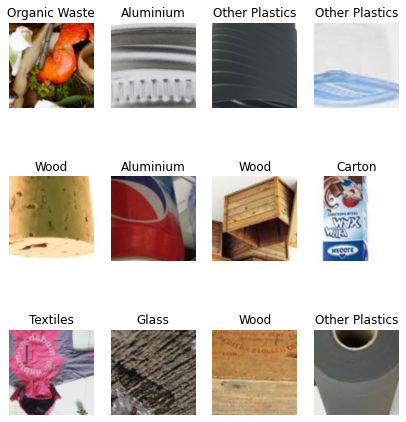

In [13]:
# Preview batch items

data.show_batch(max_n=12, nrows=3, figsize=(7, 8))

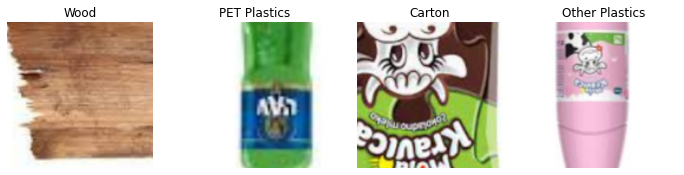

In [14]:
# View batch data augmentation on sample item

data.show_batch(max_n=4, nrows=1, unique=False)

# Section 4 - Train the Models and Interpret Results

## 1. Model Using Resnet 50 Architecture

### Train model

In [15]:
# Instantiate a learner using the resnet50 architecture and the accuracy and error rate metrics to test performance

learn1 = cnn_learner(data, resnet50, metrics=[error_rate, accuracy], bn_final=True) 

In [16]:
# Fit learner to data 

start = time()
learn1.fit_one_cycle(1)
end = time()

print("Time:", round((end - start)/60, 2), "minutes")

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.284574,0.613065,0.200000,0.800000,22:29


Time: 22.49 minutes


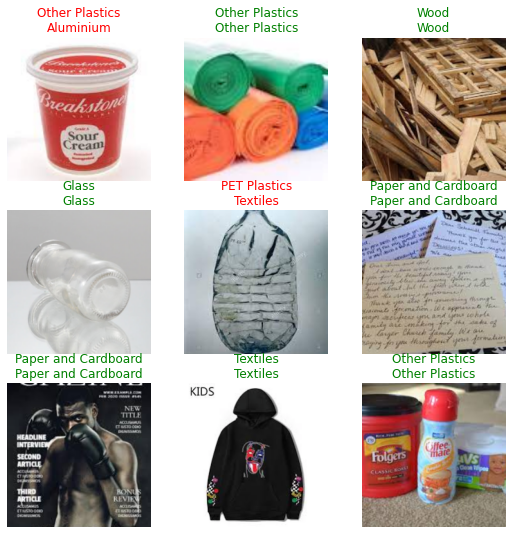

In [17]:
learn1.show_results()

In [18]:
# Save model

learn1.save('resnet50_stage1')
learn1.export('resnet50_stage1')

c:\users\sanja's pc\appdata\local\programs\python\python37\lib\site-packages\fastai\callback\schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


Time: 66.76 minutes


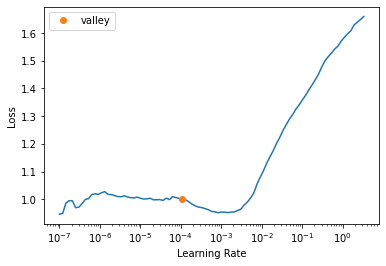

In [19]:
# Find optimal learning rate

start = time()
learn1.unfreeze() 
learn1.lr_find()
end = time()
print("Time:", round((end - start)/60, 2), "minutes")

In [20]:
# Fit learner using optimal learning rate range

start = time()
learn1.fit_one_cycle(1, lr_max=slice(1e-4, 1e-3))
end = time()
print("Time:", round((end - start)/60, 2), "minutes")

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.913376,0.576755,0.184874,0.815126,27:24


Time: 27.4 minutes


In [21]:
# Save model / Export model (save architecture and parameters it's trained on)

learn1.save('resnet50_stage2')
learn1.export('resnet50_stage2') # works better

### Interpretation

In [ ]:
# Load model

# learn1 = cnn_learner(data, resnet50, metrics=[error_rate, accuracy], bn_final=True) 
# learn1.load('resnet50_stage2') # did not work

In [ ]:
# Load model (make sure path to model is correct)

# learn1 = cnn_learner(data, resnet50, metrics=[error_rate, accuracy], bn_final=True)
# learn1.load_state_dict(torch.load("C:/Users/Sanja's PC/Desktop/Waste project/waste-images/models/resnet50_stage2.pth"), strict=False)

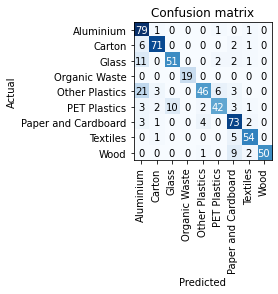

In [22]:
interpretation = ClassificationInterpretation.from_learner(learn1)
interpretation.plot_confusion_matrix()

We can see that the highest number of false predictions occured within the Other Plastics category, where the items were mainly confused with Aluminium and Carton. The model seems to make the least number of errors when classifying images from the Carton category. 

In [35]:
# See most confused waste images 

interpretation.most_confused(min_val=5)

[('Other Plastics', 'Aluminium', 21),
 ('Glass', 'Aluminium', 11),
 ('PET Plastics', 'Glass', 10),
 ('Wood', 'Paper and Cardboard', 9),
 ('Carton', 'Aluminium', 6),
 ('Other Plastics', 'PET Plastics', 6),
 ('Textiles', 'Paper and Cardboard', 5)]

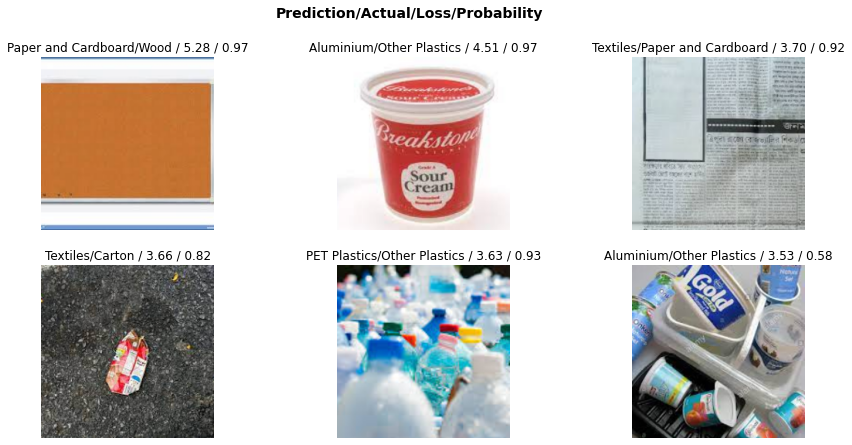

In [23]:
# Show images in `top_losses` along with their prediction, actual, loss, and probability.

interpretation.plot_top_losses(6, nrows=2, figsize=(15,7))

In [24]:
# Take a look at the validation dataset

print("Number of classes:", data.valid.c)
print("Size of dataset:", len(data.valid_ds))

Number of classes: 9
Size of dataset: 595


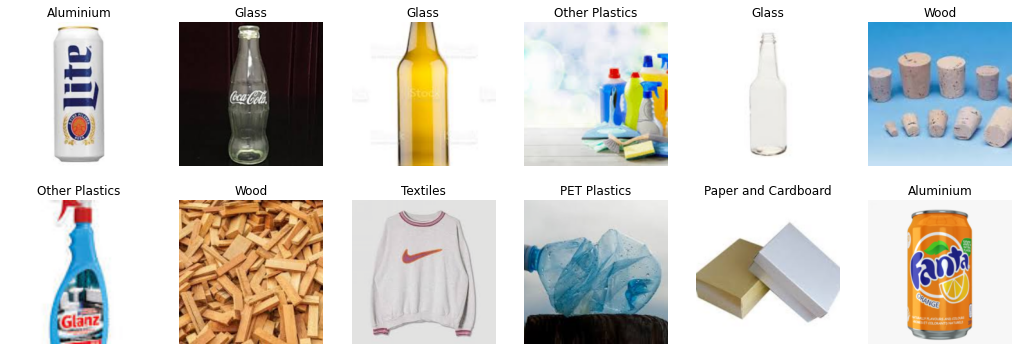

In [25]:
data.valid.show_batch(max_n=12, nrows=2)

The waste/item on this photo was classified as Aluminium with a probability of 0.5647.


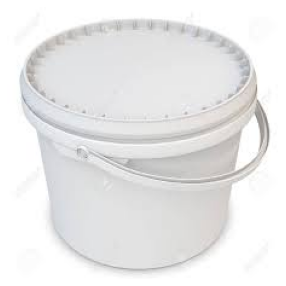

In [26]:
# Return predicted class, label and class probability for a randomly selected item from the validation dataset.

# learn_inf = load_learner(path/'resnet50_stage2.pkl') # load inference learner from the exported file

img_index = randint(0, len(data.valid_ds))
img = data.valid_ds[img_index][0]
img.show()
prediction, idx, probability = learn1.predict(img)
print(f"The waste/item on this photo was classified as {prediction} with a probability of {max(probability):0.4f}.")

## 2. Model Using Custom Architecture - Basic CNN with Batchnorm

### Train model

First example used in class

In [27]:
def conv(ni,nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [28]:
model2 = nn.Sequential(
    conv(3, 64),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    conv(64, 128),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    conv(128, 256), 
    nn.BatchNorm2d(256),
    nn.ReLU(),
    conv(256, 128),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    conv(128, 64), 
    nn.BatchNorm2d(64),
    nn.ReLU(),
    conv(64, 3), 
    nn.BatchNorm2d(3),
    Flatten()    
)

In [30]:
learn2 = Learner(data, model2, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

# learn2 = cnn_learner(data, model, metrics=accuracy)

In [31]:
learn2.fit_one_cycle(1) 

epoch,train_loss,valid_loss,accuracy,time
0,3.620528,3.387156,0.166387,02:30


In [32]:
learn2.save("custom1_stage1")
learn2.export("custom1_stage1")

c:\users\sanja's pc\appdata\local\programs\python\python37\lib\site-packages\fastai\callback\schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


Time: 6.55 minutes


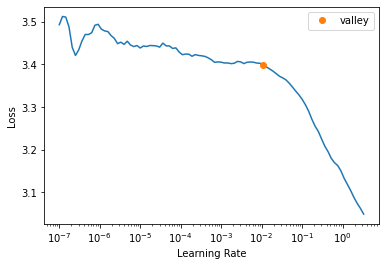

In [33]:
# Find optimal learning rate

start = time()
learn2.unfreeze() 
learn2.lr_find()
end = time()
print("Time:", round((end - start)/60, 2), "minutes")

In [36]:
learn2.fit_one_cycle(2, lr_max=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,2.845411,2.602251,0.119328,02:46
1,2.568988,2.385356,0.164706,02:45


In [37]:
learn2.load("custom1_stage1")

## 3. Model with Custom Architecture - Refactor

### Train model

Second example used in class

In [40]:
def conv2(ni,nf): return ConvLayer(ni,nf,stride=2)

In [55]:
model3 = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 10), # 1
    Flatten()      # remove (1,1) grid
)

In [56]:
learn3 = Learner(data, model3, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [57]:
learn3.fit_one_cycle(2, lr_max=0.1)

epoch,train_loss,valid_loss,accuracy,time


RuntimeError: Given groups=1, weight of size [8, 1, 3, 3], expected input[64, 3, 224, 224] to have 1 channels, but got 3 channels instead

## 4. Model with Custom Architecture - Resnet-ish

Third example used in class

### Train model

In [50]:
class ResBlock(Module):
    def __init__(self, nf):
        self.conv1 = ConvLayer(nf,nf)
        self.conv2 = ConvLayer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [58]:
model4 = nn.Sequential(
    conv2(1, 8),
    ResBlock(8),
    conv2(8, 16),
    ResBlock(16),
    conv2(16, 32),
    ResBlock(32),
    conv2(32, 16),
    ResBlock(16),
    conv2(16, 10),
    Flatten()
)

In [59]:
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), ResBlock(nf))

In [60]:
model4 = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [61]:
learn4 = Learner(data, model4, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [62]:
learn4.lr_find(end_lr=100)

RuntimeError: Given groups=1, weight of size [8, 1, 3, 3], expected input[64, 3, 224, 224] to have 1 channels, but got 3 channels instead